Используйте базу акций Лукойла.

Сделайте несколько усовершенствований в предсказании временного ряда.
Добавьте к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Примените абсолютно новый подход. Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте:

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).
* Объедините эти точки

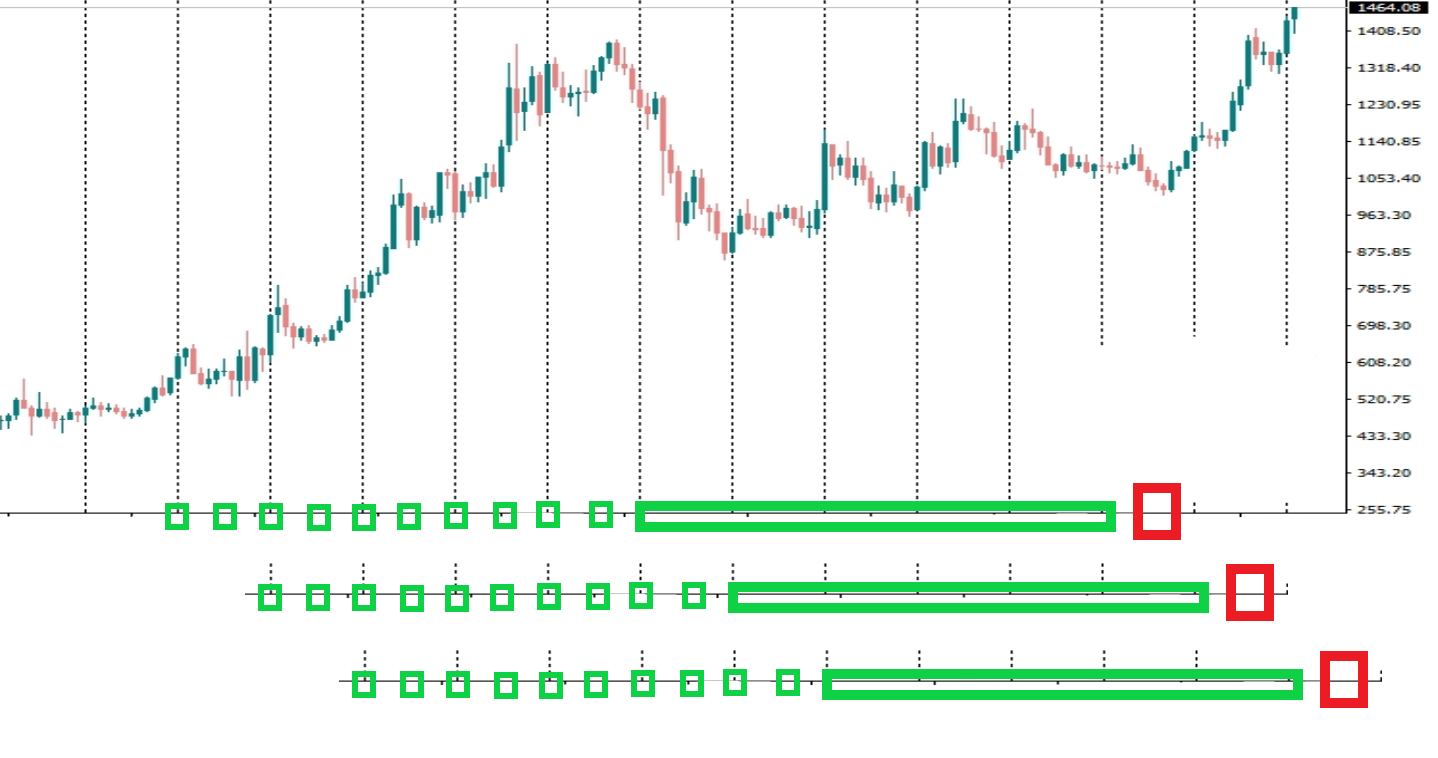

## Подготовка

In [1]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import acf

In [2]:
# Назначение размера и стиля графиков по умолчанию

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [3]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

In [4]:
# Чтение данных в таблицы с удалением ненужных столбцов

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [5]:
# Просмотр размерностей получившихся таблиц

print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [6]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17,data18_19])   # Объединение датасетов
data = data.reset_index(drop = True)      # Обнуление индексов

# Проверка формы данных
print(data.shape)

(481872, 5)


In [7]:
# Получение названий столбцов

col = data.columns
print(col)

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


In [8]:
# Задание циклов для столбцов таким образом, чтобы происходил перебор всех возможных пар:
# Перебор индексов массива с именами столбцов 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME',
# получая пары 'OPEN' и 'MAX', 'OPEN' и 'MIN', 'OPEN' и 'CLOSE' ..., 'MAX' и 'MIN', 'MAX' и 'CLOSE' и т.д

for i in range(col.shape[0]): # Для всех пар
    for j in range(i + 1 , col.shape[0]): # Расчет
        data[col[i] + '-' + col[j]] = data[col[i]] - data[col[j]] # Разности
        data['|' + col[i] + '-' + col[j] + '|'] = abs(data[col[i]] - data[col[j]]) # Модулей разностей
        data[col[i] + '*' + col[j]] = data[col[i]] * data[col[j]] # Произведения

# Для каждого столбца 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME' расчет:
for i in col:
    # Обратные значения. 1e-3 в формуле нужно, чтобы случайно не разделить на 0
    data['Обратный ' + i] = 1 / (data[i] + 1e-3)
    # Создание пустого столбца
    data['Производная от ' + i] = np.nan
    # При помощи срезов расчет первых производных, .reset_index(drop=True) нужен для корректных расчетов
    data['Производная от ' + i][1:] = data[i][1:].reset_index(drop=True) - data[i][:-1].reset_index(drop=True)
    # Создание пустого столбца
    data['Вторая производная от ' + i] = np.nan
    # При помощи срезов расчет вторых производных
    data['Вторая производная от ' + i][2:] = data[i][2:].reset_index(drop=True) - 2 * data[i][1:-1].reset_index(drop=True) + data[i][:-2].reset_index(drop=True)


In [9]:
print(data.columns)

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME', 'OPEN-MAX', '|OPEN-MAX|',
       'OPEN*MAX', 'OPEN-MIN', '|OPEN-MIN|', 'OPEN*MIN', 'OPEN-CLOSE',
       '|OPEN-CLOSE|', 'OPEN*CLOSE', 'OPEN-VOLUME', '|OPEN-VOLUME|',
       'OPEN*VOLUME', 'MAX-MIN', '|MAX-MIN|', 'MAX*MIN', 'MAX-CLOSE',
       '|MAX-CLOSE|', 'MAX*CLOSE', 'MAX-VOLUME', '|MAX-VOLUME|', 'MAX*VOLUME',
       'MIN-CLOSE', '|MIN-CLOSE|', 'MIN*CLOSE', 'MIN-VOLUME', '|MIN-VOLUME|',
       'MIN*VOLUME', 'CLOSE-VOLUME', '|CLOSE-VOLUME|', 'CLOSE*VOLUME',
       'Обратный OPEN', 'Производная от OPEN', 'Вторая производная от OPEN',
       'Обратный MAX', 'Производная от MAX', 'Вторая производная от MAX',
       'Обратный MIN', 'Производная от MIN', 'Вторая производная от MIN',
       'Обратный CLOSE', 'Производная от CLOSE', 'Вторая производная от CLOSE',
       'Обратный VOLUME', 'Производная от VOLUME',
       'Вторая производная от VOLUME'],
      dtype='object')


In [10]:
# Просмотр результатов
data

,OPEN,MAX,MIN,CLOSE,VOLUME,OPEN-MAX,|OPEN-MAX|,OPEN*MAX,OPEN-MIN,|OPEN-MIN|,...,Вторая производная от MAX,Обратный MIN,Производная от MIN,Вторая производная от MIN,Обратный CLOSE,Производная от CLOSE,Вторая производная от CLOSE,Обратный VOLUME,Производная от VOLUME,Вторая производная от VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,4.8,5538485.80,1.0,1.0,...,NaN,0.000426,NaN,NaN,0.000426,NaN,NaN,0.000393,NaN,NaN
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.8,5542726.53,2.9,2.9,...,NaN,0.000426,0.0,NaN,0.000425,5.7,NaN,0.005128,-2352.0,NaN
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,0.4,5549793.60,4.2,4.2,...,0.4,0.000425,1.4,1.4,0.000425,-1.6,-7.3,0.003891,62.0,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,0.5,5544847.50,3.3,3.3,...,-1.3,0.000425,-0.2,-1.6,0.000425,-0.4,1.2,0.001311,506.0,444.0
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.8,5538962.09,0.0,0.0,...,-0.1,0.000425,1.9,2.1,0.000425,-0.1,0.3,0.004329,-532.0,-1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523,0.0,0.0,26868672.25,0.0,0.0,...,11.5,0.000193,16.0,18.0,0.000193,11.5,10.0,0.000032,29174.0,29480.0
481868,5183.5,5183.5,5183.5,5183.5,5090,0.0,0.0,26868672.25,0.0,0.0,...,-11.5,0.000193,0.0,-16.0,0.000193,0.0,-11.5,0.000196,-26433.0,-55607.0
481869,5183.5,5183.5,5183.5,5183.5,230,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.004348,-4860.0,21573.0
481870,5183.5,5183.5,5183.5,5183.5,5,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.199960,-225.0,4635.0


In [11]:
# Использование всех столбцов, кроме первых двух
data = np.array(data.iloc[2:])

# Переменная, для использования одной и той же архитектуры под разные матрицы
columnsamount = data.shape[1]
print(columnsamount)

50


In [12]:
# Параметры для временного ряда и модели
SEQ_LEN = 200         # длина окна (количество шагов в прошлом для прогноза)
FORECAST_STEPS = 1    # количество шагов для прогноза (мы предсказываем 1 шаг)
BATCH_SIZE = 20       # размер батча для генератора

In [13]:
df = data

# Разделение данных на обучающую, проверочную и тестовую выборки (80/10/10)
total_samples = len(df)
train_size = int(total_samples * 0.8)
val_size = int(total_samples * 0.1)

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

In [14]:
# Фиксированный индекс столбца 'CLOSE' (если порядок столбцов не менялся)
close_idx = 3

# Отделяем признаки (X) и целевую переменную (y='CLOSE') для каждой выборки
X_train = np.hstack((train_data[:, :close_idx], train_data[:, close_idx+1:]))  # Все кроме 'CLOSE'
y_train = train_data[:, close_idx:close_idx+1]  # Только 'CLOSE'
X_val = np.hstack((val_data[:, :close_idx], val_data[:, close_idx+1:]))
y_val = val_data[:, close_idx:close_idx+1]
X_test = np.hstack((test_data[:, :close_idx], test_data[:, close_idx+1:]))
y_test = test_data[:, close_idx:close_idx+1]

print(f"Форма train_data: {train_data.shape}")
print(f"Индекс CLOSE: {close_idx}")
print(f"Форма первой части: {train_data[:, :close_idx].shape}")
print(f"Форма второй части: {train_data[:, close_idx+1:].shape}")
print(X_train.shape)
print(y_train.shape)

Форма train_data: (385496, 50)
Индекс CLOSE: 3
Форма первой части: (385496, 3)
Форма второй части: (385496, 46)
(385496, 49)
(385496, 1)


In [15]:
# Масштабирование признаков и целевой переменной с помощью MinMaxScaler (отдельно для X и y)
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [16]:
# Fit на обучающей выборке и трансформация всех частей данных
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled   = X_scaler.transform(X_val)
X_test_scaled  = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled   = y_scaler.transform(y_val)
y_test_scaled  = y_scaler.transform(y_test)

In [17]:
# Используем TimeseriesGenerator для создания батчей последовательностей длины SEQ_LEN
train_generator = TimeseriesGenerator(
    X_train_scaled, y_train_scaled,
    length=SEQ_LEN, batch_size=BATCH_SIZE, stride=1, sampling_rate=1
)
val_generator = TimeseriesGenerator(
    X_val_scaled, y_val_scaled,
    length=SEQ_LEN, batch_size=BATCH_SIZE, stride=1, sampling_rate=1
)
test_generator = TimeseriesGenerator(
    X_test_scaled, y_test_scaled,
    length=SEQ_LEN, batch_size=BATCH_SIZE, stride=1, sampling_rate=1
)

In [18]:
# Определяем архитектуру нейронной сети
n_features = X_train_scaled.shape[1]  # число входных признаков
model = Sequential()
model.add(Conv1D(filters=50, kernel_size=5, activation='linear',
                 input_shape=(SEQ_LEN, n_features)))
model.add(Flatten())
model.add(Dense(10, activation='linear'))
model.add(Dense(FORECAST_STEPS, activation='linear'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 196, 50)        │        12,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        98,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,321 (430.94 KB)

 Trainable params: 110,321 (430.94 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Компиляция модели с оптимизатором Adam и функцией потерь MSE
model.compile(optimizer=Adam(), loss='mse')

# Обучение модели на генераторе обучающей выборки с проверкой на валидционной выборке
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    shuffle=False
)

Epoch 1/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - loss: 0.4669 - val_loss: 0.1729
Epoch 2/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - loss: 0.1795 - val_loss: 0.0390
Epoch 3/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - loss: 0.0242 - val_loss: 0.0310
Epoch 4/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - loss: 9.1299e-04 - val_loss: 0.0197
Epoch 5/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - loss: 0.0027 - val_loss: 0.0761
Epoch 6/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - loss: 0.0039 - val_loss: 0.0338
Epoch 7/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - loss: 0.0028 - val_loss: 0.0471
Epoch 8/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 85s 4ms/step - loss: 0.0037 - val_loss: 0.0454
Epoch 9/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 0.0033 - val_loss: 0.0458
Epoch 10/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - loss: 0.0020 - val_loss: 0.0362
Epoch 11/20
19265/19265 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 0.0096 - val_loss: 

In [20]:
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания

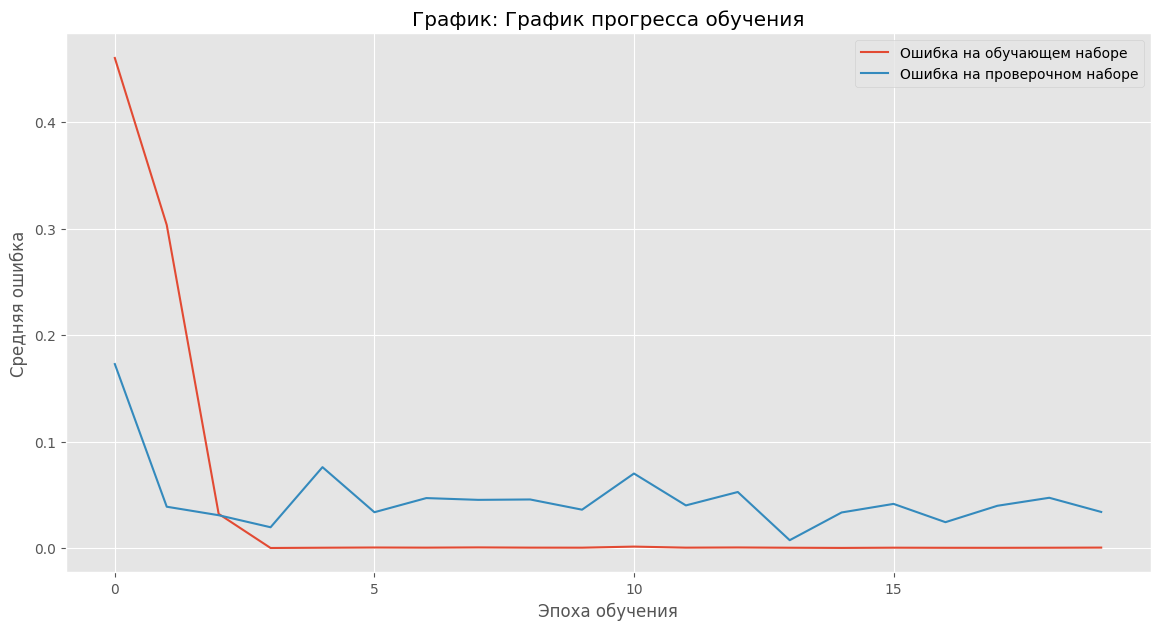

In [21]:
# Рисование графиков прошедшей фазы обучения
title = 'График'
fig = plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.title(f'{title}: График прогресса обучения')
# Указание показывать только целые метки шкалы оси x
fig.gca().xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [22]:
def eval_net(model, generator, y_scaler, lags=50):
    """
    Улучшенная функция оценки модели с корректным построением графиков:
    1. Сопоставление фактического и прогнозного рядов
    2. График автокорреляции остатков
    3. График корреляции с разными лагами (по вашему примеру)
    """
    # Собираем все предсказания и реальные значения
    pred_scaled = []
    y_true_scaled = []

    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        batch_pred = model.predict(x_batch, verbose=0)
        pred_scaled.append(batch_pred)
        y_true_scaled.append(y_batch)

    # Объединяем все батчи
    pred_scaled = np.concatenate(pred_scaled)
    y_true_scaled = np.concatenate(y_true_scaled)

    # Преобразуем обратно к исходному масштабу
    pred = y_scaler.inverse_transform(pred_scaled)
    y_true = y_scaler.inverse_transform(y_true_scaled)

    # Проверяем размерности
    if pred.ndim == 1:
        pred = pred.reshape(-1, 1)
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)

    # --- График 1: фактические vs прогнозные значения ---
    plt.figure(figsize=(14, 7))
    plt.plot(y_true[:, 0], label='Фактические значения', color='blue')
    plt.plot(pred[:, 0], label='Прогнозные значения', color='red', alpha=0.7)
    plt.title('Сопоставление фактических и прогнозных значений CLOSE')
    plt.xlabel('Временной шаг')
    plt.ylabel('Значение CLOSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- График 3: корреляция с разными лагами (новый метод) ---
    def correlate(a, b):
        return np.corrcoef(a, b)[0, 1]

    y_len = len(y_true)
    steps = range(0, min(lags, y_len//2))  # Ограничиваем максимальный лаг

    cross_corr = [correlate(y_true[:y_len-step, 0], pred[step:, 0]) for step in steps]
    auto_corr = [correlate(y_true[:y_len-step, 0], y_true[step:, 0]) for step in steps]

    plt.figure(figsize=(14, 7))
    plt.plot(steps, cross_corr, label='Прогноз vs Факт')
    plt.plot(steps, auto_corr, label='Автокорреляция факта')
    plt.title('Корреляция с разными лагами')
    plt.xticks(steps[::5])
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.grid(True)
    plt.show()

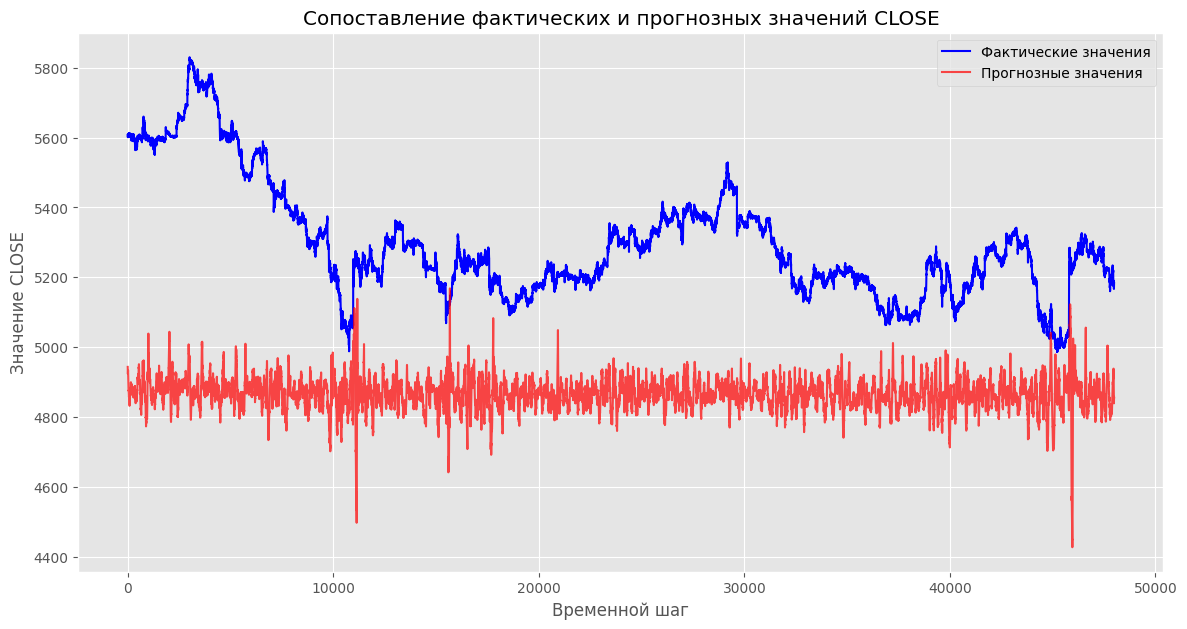

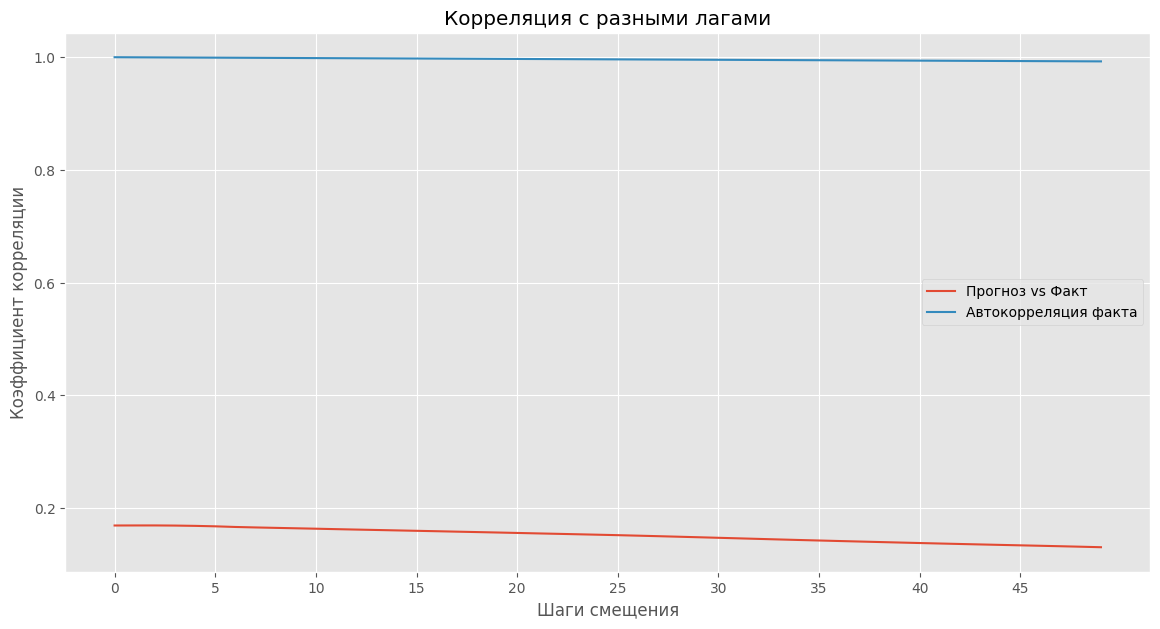

NameError: name 'residuals' is not defined

In [23]:
eval_net(model, test_generator, y_scaler, lags=50)